# Computer Vision - Exercise 7
Olivier Kanamugire

09.03.2025

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from mpl_toolkits.mplot3d import Axes3D

## Task 1

#####  a)Load data from cube_points.mat. Coordinates of cube corners in 3D are given as 3 × 8 matrix points3d. The respective projected points are given in 2 × 8 matrix points2d. Plot original 3D points on the first plot, and then plot projected 2D points on the second plot. You can also use connecting_indices vector to connect the points into a cube.

In [2]:
# TODO load file cube_points.mat
with h5py.File('cube_points.mat', 'r') as f:
    points3d = f['points3d'][:]
    points2d = f['points2d'][:]
    connecting_indices = f['connecting_indices'][:]

# Check the structure of the loaded data
print(f"points3d: {points3d.shape}")
print(f"points2d: {points2d.shape}")
print(f"connecting_indices: {connecting_indices.shape}")

points3d: (8, 3)
points2d: (8, 2)
connecting_indices: (17,)


In [3]:
def plot_projection(points, connecting_indices, ax=None):
    """Plot 2D projection of the cube."""
    if ax is None:
        ax = plt.gca()

    # Ensure points have the correct shape (N, 2)
    points = np.array(points)

    # Scatter plot of the 2D points
    ax.scatter(points[:, 0], points[:, 1], color='r', s=100, label="Projected Points")

    # Use connecting_indices to plot lines connecting the points to form the cube
    for i in range(len(connecting_indices) - 1):  
        idx1, idx2 = connecting_indices[i], connecting_indices[i + 1]
        ax.plot([points[idx1, 0], points[idx2, 0]], 
                [points[idx1, 1], points[idx2, 1]], 
                color='b', lw=2)  

    ax.set_aspect("equal", adjustable="box")  
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("2D Projection of Cube")
    ax.legend()


In [4]:
# 3D GRAPHING
def plot_3d_cube(points3d, connecting_indices, ax):
    """Plot the 3D cube using given 3D points and edges."""
    ax.scatter(points3d[:, 0], points3d[:, 1], points3d[:, 2], c='r', marker='o', label="3D Points")

    # Draw cube edges
    for i in range(len(connecting_indices) - 1):
        idx1, idx2 = connecting_indices[i], connecting_indices[i + 1]
        ax.plot([points3d[idx1, 0], points3d[idx2, 0]],
                [points3d[idx1, 1], points3d[idx2, 1]],
                [points3d[idx1, 2], points3d[idx2, 2]], 'b')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("A plot of Cube ")
    ax.view_init(elev=20, azim=30)  
    ax.legend()

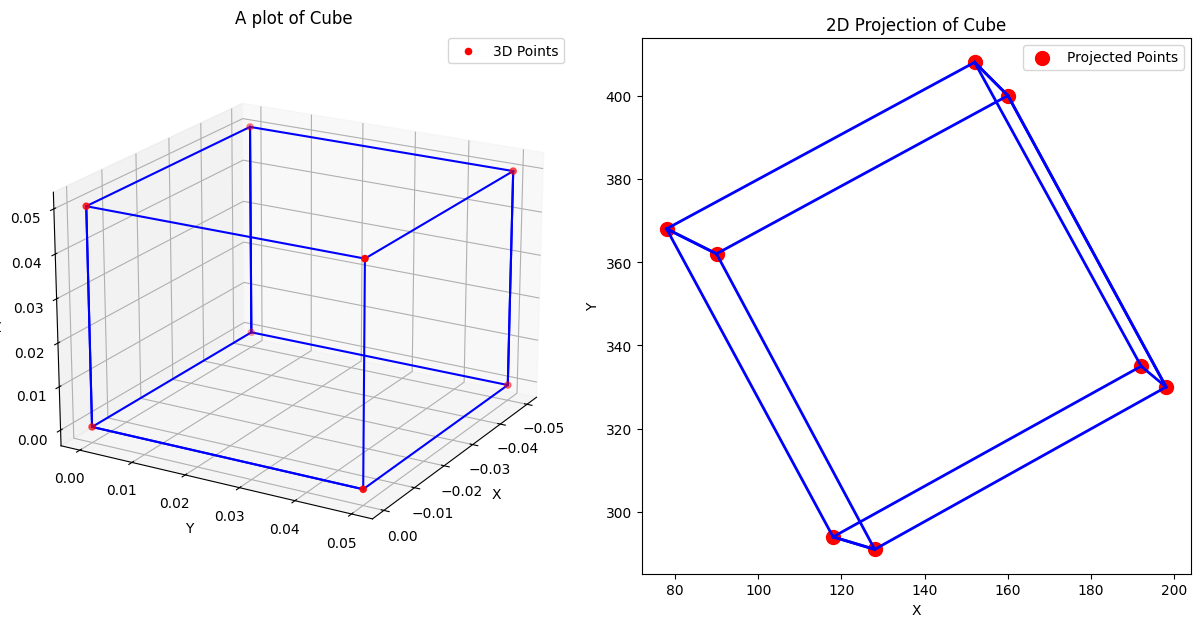

In [5]:
# TODO plot the 3D cube and the projection nicely side by side
# you can use matplotlib for both, it will be easier than using pyvista

# Convert connecting indices to 0-based index
connecting_indices = connecting_indices.flatten() - 1  

# Create figure with two subplots
fig = plt.figure(figsize=(12, 6))

# 3D Cube Plot 
ax1 = fig.add_subplot(121, projection='3d')
plot_3d_cube(points3d, connecting_indices, ax1)

# 2D Projection Plot 
ax2 = fig.add_subplot(122)
plot_projection(points2d, connecting_indices, ax2)

plt.tight_layout()
plt.show()


#### b) Implement function $\texttt{calibrate(points3d, points2d)}$ that performs direct-lineartransform (DLT) and finds a suitable projection matrix that would project points3d to points2d. Apply that function to the given points to find projection matrix M.

In [6]:
def calibrate(points3d, points2d):
    """Performs Direct Linear Transform (DLT) to compute projection matrix M."""
    # Ensure correct shape (N, 3) and (N, 2) for iteration
    points3d = np.asarray(points3d)  
    points2d = np.asarray(points2d)

    N = points3d.shape[0]  # Number of points

    A = []
    for i in range(N):
        X, Y, Z = points3d[i, :]  
        u, v = points2d[i, :]

        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

    A = np.array(A)

    # Solve for M using SVD
    U, S, Vt = np.linalg.svd(A)
    # Last row of Vt gives solution
    M = Vt[-1, :].reshape(3, 4)  

    return M


In [7]:
# TODO perform calibration and apply it to the 3D points

M = calibrate(points3d, points2d)
print("Projection Matrix M:\n", M)

Projection Matrix M:
 [[-5.98056159e-01 -3.10160416e-01  1.28922674e-01 -6.72681342e-02]
 [-3.52861604e-01  6.02738041e-01  9.44944016e-02 -1.68075258e-01]
 [-9.10182962e-05  4.96461816e-05  3.99775047e-04 -4.20285073e-04]]


#### c)The projection of given 3D points onto the 2D plane can be achieved using the projection matrix $M$ . Given a set of 3D points $ \mathbf{p}_i = (x_i, y_i, z_i)$ where $ i = 1, \dots, N $, the projection of these points onto the 2D plane is calculated as follows: $$ \hat{\mathbf{p}}_i = M \cdot \mathbf{p}_i $$ where  $\hat{\mathbf{p}}_i = (x'_i, y'_i) $ represents the 2D projection of the 3D point $ \mathbf{P}_i $ using the projection matrix $ M $. The matrix $ M $ is a $3 \times 4$ matrix that transforms the 3D coordinates into 2D coordinates. We also Calculate reprojection error by using the formula $$E(\hat{p},p) = \frac{1}{N}\sum_i^N ||p-\hat{p}||_2$$ where $p$ are the given 2D points, $\hat{p}$ are the projected points using matrix $M$ and $||p_i − \hat{p}_i||_2$ is the Euclidean distance between them.

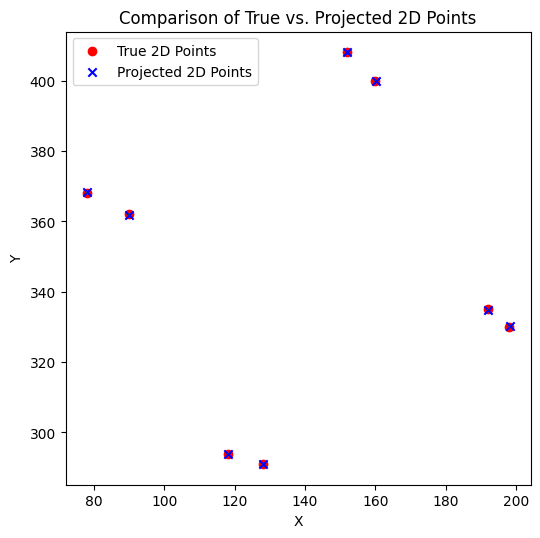

In [8]:
# TODO plot the results

def project_points(points3d, M):
    """Project 3D points using projection matrix M."""
    num_points = points3d.shape[0]
    
    # Convert points3d to homogeneous coordinates (add a column of ones)
    points3d_h = np.hstack((points3d, np.ones((num_points, 1))))  
    
    # Apply projection matrix
    projected_h = M @ points3d_h.T  
    
    # Convert from homogeneous to 2D (normalize by last row)
    projected_2d = projected_h[:2] / projected_h[2]  # (2, 8)

    return projected_2d.T  

#Apply projection 
projected_2d = project_points(points3d, M)

#Plot original vs projected points
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(points2d[:, 0], points2d[:, 1], color='r', marker='o', label="True 2D Points")
ax.scatter(projected_2d[:, 0], projected_2d[:, 1], color='b', marker='x', label="Projected 2D Points")

for i in range(points2d.shape[0]):
    ax.plot([points2d[i, 0], projected_2d[i, 0]], 
            [points2d[i, 1], projected_2d[i, 1]], 'g--')  

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Comparison of True vs. Projected 2D Points")
ax.legend()
ax.set_aspect("equal", adjustable="box")

plt.show()


In [9]:
# TODO calcuate reprojection error and print it

def compute_reprojection_error(points2d, projected_2d):
    """Compute the reprojection error."""
    N = points2d.shape[0]
    
    # Compute Euclidean distance for each point
    error = np.linalg.norm(points2d - projected_2d, axis=1)
    
    # Mean reprojection error
    return np.sum(error**2) / N


# Compute reprojection error 
reprojection_error = compute_reprojection_error(points2d, projected_2d)
print(f"Reprojection Error: {reprojection_error:.6f}")



Reprojection Error: 0.026542


#### d) Enhance your code by adding normalization. Either write a separate function for calibration with normalization, or add it as an option to already implemented calibrate function. The new function must find the projection matrix of the perspective projection with point normalization. Remember to perform both normalization before the DLT and then denormalization afterwards!

Lets write functions to normalize the points 

In [10]:
def normalize_points_2d(points2d):
    """Normalize 2D points: translate mean to (0,0) and scale so avg distance is sqrt(2)."""
    mean = np.mean(points2d, axis=0)  
    std_dev = np.std(points2d, axis=0)  
    T = np.array([
        [np.sqrt(2) / std_dev[0], 0, -np.sqrt(2) / std_dev[0] * mean[0]],
        [0, np.sqrt(2) / std_dev[1], -np.sqrt(2) / std_dev[1] * mean[1]],
        [0, 0, 1]
    ])

    points_h = np.hstack((points2d, np.ones((points2d.shape[0], 1)))) 
    normalized_points = (T @ points_h.T).T[:, :2]  

    return normalized_points, T

def normalize_points_3d(points3d):
    """Normalize 3D points: translate mean to (0,0,0) and scale so avg distance is sqrt(3)."""
    mean = np.mean(points3d, axis=0)  
    std_dev = np.std(points3d, axis=0)  

    T = np.array([
        [np.sqrt(3) / std_dev[0], 0, 0, -np.sqrt(3) / std_dev[0] * mean[0]],
        [0, np.sqrt(3) / std_dev[1], 0, -np.sqrt(3) / std_dev[1] * mean[1]],
        [0, 0, np.sqrt(3) / std_dev[2], -np.sqrt(3) / std_dev[2] * mean[2]],
        [0, 0, 0, 1]
    ])

    points_h = np.hstack((points3d, np.ones((points3d.shape[0], 1))))  
    normalized_points = (T @ points_h.T).T[:, :3]  
    return normalized_points, T

In [11]:
def calibrate_norm(points2d, points3d):
    """Finds the projection matrix with normalization."""
    # Normalize points
    normalized_2d_pts, T2d = normalize_points_2d(points2d)
    normalized_3d_pts, T3d = normalize_points_3d(points3d)

    # Apply DLT to normalized points
    M = calibrate(normalized_3d_pts, normalized_2d_pts)  

    # Denormalize projection matrix
    denormalized_M = np.linalg.inv(T2d) @ M @ T3d  

    return denormalized_M

In [12]:
M_normalized = calibrate_norm(points2d, points3d)
print("Projection Matrix M:\n", M_normalized)

Projection Matrix M:
 [[ 9.62751665e+02  4.99552071e+02 -2.07546202e+02  1.08299703e+02]
 [ 5.67674268e+02 -9.70089140e+02 -1.52060159e+02  2.70596288e+02]
 [ 1.45187387e-01 -7.88136369e-02 -6.43435845e-01  6.76642351e-01]]


Lets calculate error and  compare it with the one  without normalization


In [13]:
projected_2d_norm = project_points(points3d, M_normalized)

In [14]:
reprojection_error_norm = compute_reprojection_error(points2d, projected_2d_norm)
print(f"Reprojection Error: {reprojection_error_norm:6f}")

Reprojection Error: 0.026529


#### The projected points are very close to the original ones. The squared distance between the original and projected points shows a small improvement after normalization. However, in both cases, the accuracy remains high. With four decimal places, the reprojection error remains the same at 0.0265.

#### e)In real-life scenario, exact coordinates are quite difficult to acquire, the locations are not exact and noisy. Compare results with and without normalization using data from cube_points_noisy.mat. Are they improved with normalization? Are the new reprojected points visually closer to the given 2D points? Is reprojection error smaller?

In [15]:
# TODO load file cube_points_noisy.mat
with h5py.File('cube_points_noisy.mat', 'r') as f:
    points3d_noisy = f['points3d_noisy'][:]
    points2d_noisy = f['points2d_noisy'][:]
    connecting_indices = f['connecting_indices'][:]

# Check the structure of the loaded data
print(f"points3d: {points3d_noisy.shape}")
print(f"points2d: {points2d_noisy.shape}")
print(f"connecting_indices: {connecting_indices.shape}")

points3d: (8, 3)
points2d: (8, 2)
connecting_indices: (17,)


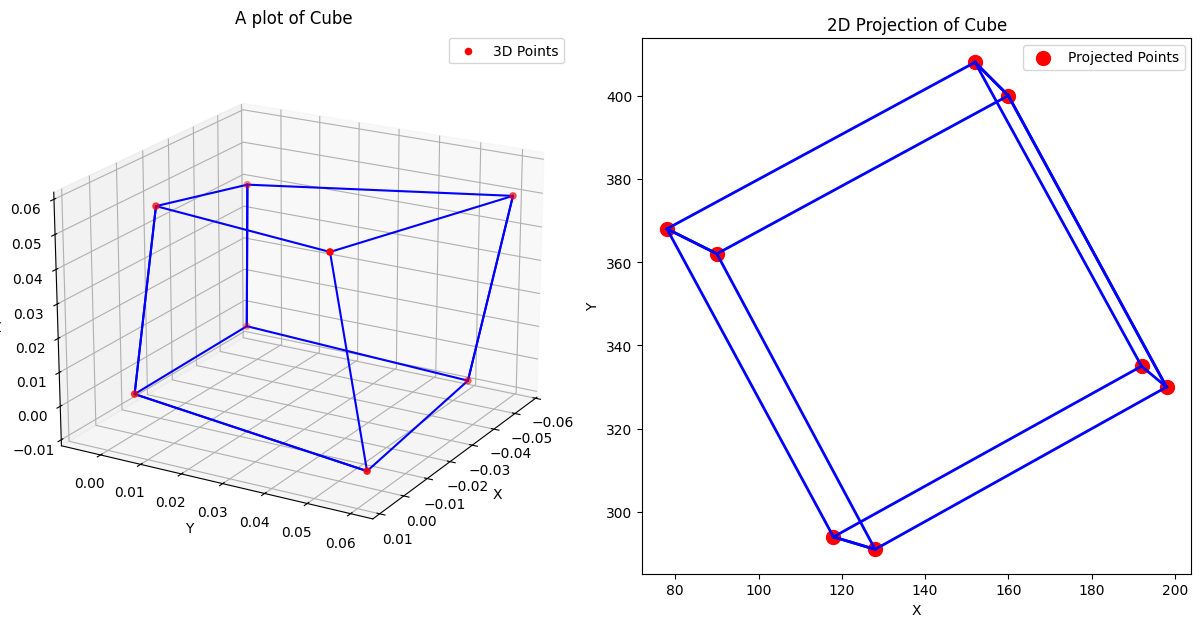

In [16]:
# TODO plot the noisy 3D cube and noisy projection side by side so you can see what you are dealing with

# Convert connecting indices to 0-based index
connecting_indices = connecting_indices.flatten() - 1  

# Create figure with two subplots
fig = plt.figure(figsize=(12, 6))

# 3D Cube Plot 
ax1 = fig.add_subplot(121, projection='3d')
plot_3d_cube(points3d_noisy, connecting_indices, ax1)

# 2D Projection Plot 
ax2 = fig.add_subplot(122)
plot_projection(points2d_noisy, connecting_indices, ax2)

plt.tight_layout()
plt.show()

In [17]:
# TODO calibrate without normalization
M_noisy = calibrate(points3d_noisy, points2d_noisy)
print('The Calibration matrix: \n', M_noisy)

# TODO apply the calculated transformation
projected_2d_noisy = project_points(points3d_noisy,M_noisy)

# TODO calculate the error
error_noisy = compute_reprojection_error(points2d_noisy, projected_2d_noisy)
print("Reprojection Error without Normalization (Noisy Data):", error_noisy)

The Calibration matrix: 
 [[-4.50703916e-01  1.10741086e-02  1.73384486e-02 -2.94125317e-02]
 [-8.23490675e-01  3.35379800e-01  5.74540955e-03 -7.01651504e-02]
 [-2.14205412e-03  5.82523046e-04  6.76778479e-05 -1.81914813e-04]]
Reprojection Error without Normalization (Noisy Data): 3274.749663146234


In [18]:
# TODO calibrate with normalization
M_noisy_norm = calibrate_norm( points2d_noisy, points3d_noisy)

# TODO apply the calculated transformation
projected_2d_noisy_norm = project_points(points3d_noisy,M_noisy_norm)

# TODO calculate the error
error_noisy_norm = compute_reprojection_error(points2d_noisy, projected_2d_noisy_norm)
print("Reprojection Error with Normalization (Noisy Data):", error_noisy_norm)


Reprojection Error with Normalization (Noisy Data): 61.84492509760206


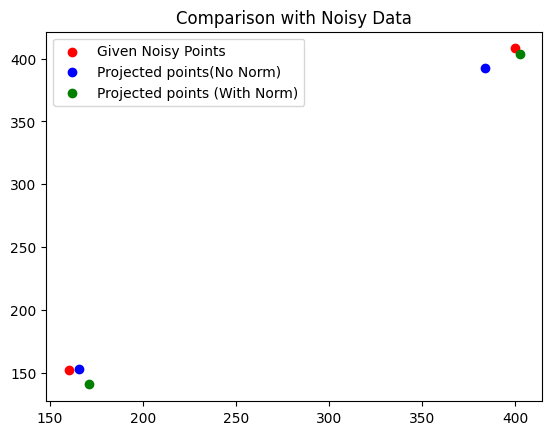

In [19]:
# TODO compare the two results

plt.figure()
plt.scatter(points2d_noisy[0, :], points2d_noisy[1, :], c='r', label="Given Noisy Points")
plt.scatter(projected_2d_noisy[0, :], projected_2d_noisy[1, :], c='b', label="Projected points(No Norm)")
plt.scatter(projected_2d_noisy_norm[0, :], projected_2d_noisy_norm[1, :], c='g', label="Projected points (With Norm)")
plt.legend()
plt.title("Comparison with Noisy Data")
plt.show()

#### As anticipated, projecting the 2D version with noisy data is challenging. However, applying normalization significantly reduces the error. The calculated error decreased from 3274.75 to 61.85 after normalization, demonstrating its positive impact.

⚠️ TODO: Answer the questions ⚠️

## Task 2

In [20]:
from scipy.linalg import rq

def decompose_projection(M):
    """Decomposes the projection matrix M into intrinsic matrix K, rotation matrix R, and camera center C."""
    
    # Ensure the input matrix M is a 3x4 matrix
    assert M.shape == (3, 4), "Input matrix M must be of shape (3, 4)."

    # Decompose the 3x3 part of the projection matrix M using RQ decomposition
    K, R = rq(M[:, :3]) 
    
    # Correct the sign of R and K so that the determinant of K is positive
    R = R * np.sign(K[-1, -1])
    K = K * np.sign(K[-1, -1])

    # Camera center C 
    # To get the camera center, we solve the equation M[:, :3] * C = -M[:, 3]
    # This corresponds to the inverse of the camera matrix.
    b = np.zeros(4)
    C = np.linalg.solve(M[:, :3], -M[:, 3])  # Solve for C

    return K, R, C

In [34]:
M[:, 3]


array([-0.06726813, -0.16807526, -0.00042029])

In [32]:
M[:, 3]

array([-0.06726813, -0.16807526, -0.00042029])

In [ ]:
M_hom  = np.vstack(M,[0,0,])

array([[-5.98056159e-01, -3.10160416e-01,  1.28922674e-01,
        -6.72681342e-02],
       [-3.52861604e-01,  6.02738041e-01,  9.44944016e-02,
        -1.68075258e-01],
       [-9.10182962e-05,  4.96461816e-05,  3.99775047e-04,
        -4.20285073e-04]])

In [21]:
K, R, C = decompose_projection(M)

#### Function to reconstruct M from decomposed matrix

In [22]:
def verify_decomposition(K, R, C):
    # Reconstruct the projection matrix from the decomposed parts
    M_reconstructed = K @ np.hstack((R, -R @ C.reshape(-1, 1)))
    
    return M_reconstructed

In [23]:

M = M # TODO use the matrix created in Task 1
K, R, C = decompose_projection(M) 

M_reconstructed = verify_decomposition(K, R, C)

print(f"The result is {' the same.' if np.allclose(M, M_reconstructed) else 'not the dame!'}")


The result is  the same.


In [24]:
K.shape, R.shape, C.shape

((3, 3), (3, 3), (3,))

In [25]:
K

array([[ 6.49426619e-01, -2.52801149e-02,  2.19311858e-01],
       [-0.00000000e+00,  6.62057984e-01,  2.41687556e-01],
       [-0.00000000e+00, -0.00000000e+00,  4.13000195e-04]])

In [26]:
def plot_frame(ax, T, name=""):
    """Function that plots the world frames"""
    # Origin
    l = 0.25
    ax.quiver(T[0, 3], T[1, 3], T[2, 3], T[0, 0], T[1, 0], T[2, 0], color="r", length=l)
    ax.quiver(T[0, 3], T[1, 3], T[2, 3], T[0, 1], T[1, 1], T[2, 1], color="g", length=l)
    ax.quiver(T[0, 3], T[1, 3], T[2, 3], T[0, 2], T[1, 2], T[2, 2], color="b", length=l)

    ax.text(T[0, 3] + T[0, 0] * l, T[1, 3] + T[1, 0] * l, T[2, 3] + T[2, 0] * l, f"{name}X")
    ax.text(T[0, 3] + T[0, 1] * l, T[1, 3] + T[1, 1] * l, T[2, 3] + T[2, 1] * l, f"{name}Y")
    ax.text(T[0, 3] + T[0, 2] * l, T[1, 3] + T[1, 2] * l, T[2, 3] + T[2, 2] * l, f"{name}Z")

    ax.set_aspect("equal", adjustable="box")

In [27]:
# Camera Matrix (example 4x4)
RT = np.hstack((R, -C.reshape(-1, 1)))
    
# Combine K with [R | -C] 
T_camera = K @ RT


In [28]:
T_camera

array([[-5.98056159e-01, -3.10160416e-01,  1.28922674e-01,
        -2.51495568e-01],
       [-3.52861604e-01,  6.02738041e-01,  9.44944016e-02,
        -3.44116819e-01],
       [-9.10182962e-05,  4.96461816e-05,  3.99775047e-04,
        -4.30858579e-04]])

In [29]:
T_camera_homogeneous = np.vstack((T_camera, np.array([0, 0, 0, 1])))

T_camera_homogeneous

array([[-5.98056159e-01, -3.10160416e-01,  1.28922674e-01,
        -2.51495568e-01],
       [-3.52861604e-01,  6.02738041e-01,  9.44944016e-02,
        -3.44116819e-01],
       [-9.10182962e-05,  4.96461816e-05,  3.99775047e-04,
        -4.30858579e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

## Plotting


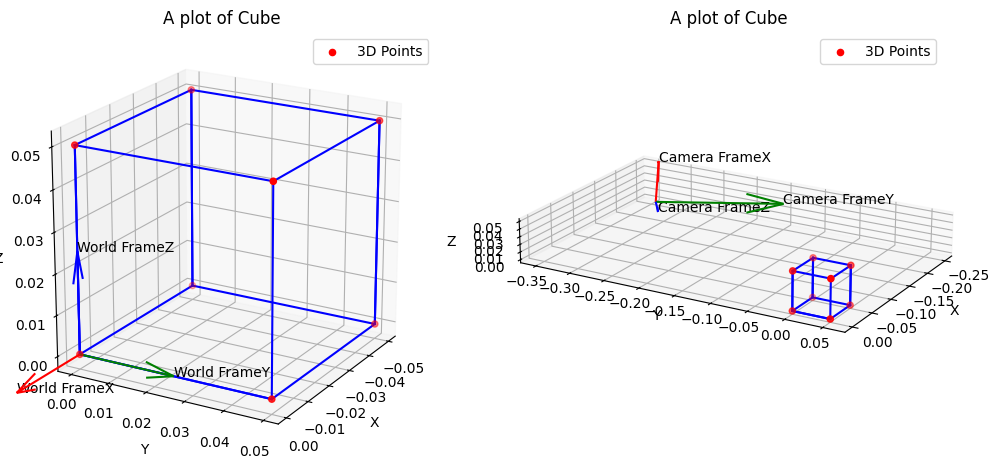

In [30]:
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot the cube and world frame in first subplot
ax1 = fig.add_subplot(121, projection='3d')
plot_3d_cube(points3d, connecting_indices, ax1)
plot_frame(ax1, 0.1*np.eye(4), name="World Frame")  

# Plot the cube and camera fraame in second subplot
ax2 = fig.add_subplot(122, projection='3d')
plot_3d_cube(points3d, connecting_indices, ax2)
plot_frame(ax2, T_camera_homogeneous, name="Camera Frame")

plt.show()


#### $\textcircled{A}$ Attention
 * Because of axes of boxes, I have multiplied 0.1 to the world frame so that it can be seen more clearly.